In [1]:
''' This is the main script to run the DQN algorithm. '''
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import time
import json
import math
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname("test_hac_foo.ipynb"))))))
os.environ["cuda_visible_devices"]="1"



In [2]:
# import neccessary modules
from Top_Opt_RL.DQN.FEA_SOLVER_GENERAL import *
from Top_Opt_RL.DQN.opts import parse_opts
from Top_Opt_RL.DQN.TopOpt_Env_Functions import TopOpt_Gen, Prog_Refine_Act,User_Inputs,App_Inputs, Testing_Inputs, Testing_Info, Min_Dist_Calc  
from Top_Opt_RL.DQN.Matrix_Transforms import obs_flip, action_flip, Mesh_Transform, Mesh_Triming 
from Top_Opt_RL.DQN.RL_Necessities import Agent 
from Plot_Layout import plot_layout

In [3]:
''' 
Class for Topology Optimization Options
'''
class Top_Options:
    def __init__(self, Main_EX=24, Main_EY=24, PR2_EX=12, PR2_EY=12, PR_EX=6, PR_EY=6, Lx=1, Ly=1, Eta=2, a=5, b=5, replace=100, epsilon_dec=3.5e-4, eps_end=0.01, mem_size=30000, n_games=50000, batch_size=128, lr=5e-3, gamma=0.1, Vol_Frac_1=0.7, Vol_Frac_2=0.5, Vol_Frac_3=0.25, SC=10, P_Norm=10, filename_save='DDQN_TopOpt_Generalized_CNN_4L', filename_load='DDQN_TopOpt_Generalized_CNN_4L_6by6', Progressive_Refinement=True, LC=False, Load_Checkpoints=True, VF_S=0, Min_Dist=0, Time_Trial=True, configfile='config.json', From_App=True, base_folder="."):
        self.Main_EX = Main_EX  # Number of X Elements for Larger Environment
        self.Main_EY = Main_EY  # Number of Y Elements for Larger Environment
        self.PR2_EX = PR2_EX  # Number of X Elements for Second Environment used in Case of Progressive Refinement
        self.PR2_EY = PR2_EY  # Number of Y Elements for Second Environment used in Case of Progressive Refinement
        self.PR_EX = PR_EX  # Number of X Elements for Smaller Environment used in Case of Progressive Refinement
        self.PR_EY = PR_EY  # Number of Y Elements for Smaller Environment used in Case of Progressive Refinement
        self.Lx = Lx  # Length of the Structure in the X Direction
        self.Ly = Ly  # Length of the Structure in the Y Direction
        self.Eta = Eta  # Used for dynamic adjusting reward function. Larger eta means less prevalence given towards changes between current and previous reward. Recommend using [2,4]
        self.a = a  # X Coefficient of the Quadratic Reward Surface
        self.b = b  # Y Coefficient of the Quadratic Reward Surface
        self.replace = replace  # Number of iterations between switching the weights from the active network to the target network
        self.epsilon_dec = epsilon_dec  # Iterative decay amount of the epsilon value used for exploration/explotation
        self.eps_end = eps_end  # Smallest Allowable Epsilon value to be used for exploration/explotation
        self.mem_size = mem_size  # Size of the Replay Buffer
        self.n_games = n_games  # Maximum Number of Training Episodes Conducted
        self.batch_size = batch_size  # Batch Size that will be taken from the Replay Buffer per training episode
        self.lr = lr  # Starting Learning Rate for the Network
        self.gamma = gamma  # Discount Factor for Future Rewards
        self.Vol_Frac_1 = Vol_Frac_1  # Volume Fraction during first progressive refinement
        self.Vol_Frac_2 = Vol_Frac_2  # Final Volume Fraction
        self.Vol_Frac_3 = Vol_Frac_3  # Final Volume Fraction
        self.SC = SC  # Stress constraint, between 0 and 2
        self.P_Norm = P_Norm  # Smoothing Parameter for P-Norm Global Stress calculation
        self.filename_save = filename_save  # When training, what name would you like your weights, and figure saved as
        self.filename_load = filename_load  # When testing, what name is your NN weights saved under
        self.Progressive_Refinement = Progressive_Refinement
        self.LC = LC # type in loading conditions manually
        self.Load_Checkpoints = Load_Checkpoints
        self.VF_S = VF_S # Use vol fraction constraint [0] or stress constraint [1]
        self.Min_Dist = Min_Dist # The 0 value serves as a place holder to represent the minimum distance between the bounded and loaded elements in a given load case
        self.Time_Trial = Time_Trial # Perform Time Trial
        self.configfile = configfile # name of config file. 
        self.From_App = From_App # True if being called by an external app. Not sure this is needed. "
        self.base_folder = base_folder # Folder where to find saved files. Helpful if not running the app from the main folder. 



In [4]:
VF = 0.5 # Volume Fraction
SC = 10. # Stress Constraint
opts = Top_Options()
opts.Main_EY, opts.Main_EX = 6, 6
opts.PR2_EX, opts.PR2_EY = 6, 6
opts.PR_EX, opts.PR_EY = 6, 6
env = TopOpt_Gen(opts.Main_EX,opts.Main_EY,VF,SC,opts)

In [5]:
agent = Agent(env, opts, False, n_actions=opts.Main_EX*opts.Main_EY, input_dims=[opts.Main_EX,opts.Main_EY,3], epsilon=1.0, filename_save=opts.filename_save, filename_load=opts.filename_load, EX=opts.Main_EX, EY=opts.Main_EY)

In [6]:
''' Agent Training '''
# initialize 
agent.env.reset_conditions()
obs = agent.env.reset() 
rew = 0 # initial reward (check if the current action is valid)
eps = agent.epsilon
FEA_SKIP = 10 # do FEA for every 10 steps
TEST_FREQ = 5 # test every 5 episodes


ep = 0, mse = 0.5, eps = 1.0, done = False
ep = 0, mse = 0.5, eps = 1.0, done = False
ep = 0, mse = 0.5, eps = 1.0, done = False
ep = 0, mse = 0.5, eps = 1.0, done = True
g_new = 1.5689162409951585
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1.]
 [2. 1. 1. 1. 1. 4.]]

Strain Energy for Final Topology: 156.5
Maximum P_Norm Stress Perc Increase: 0.04
Final Volume Fraction: 0.917
----------------


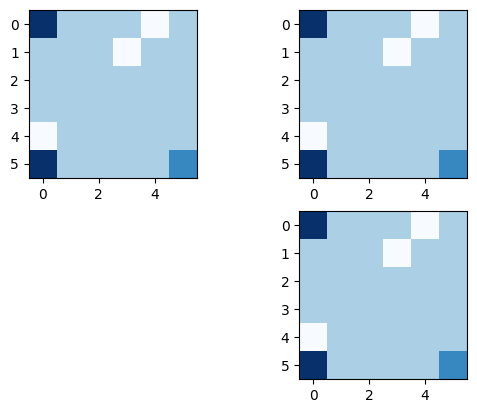

ep = 1, mse = 0.5, eps = 1.0, done = False
ep = 1, mse = 0.5, eps = 1.0, done = False
ep = 1, mse = 0.5, eps = 1.0, done = False
ep = 1, mse = 0.5, eps = 1.0, done = False
ep = 1, mse = 0.5, eps = 1.0, done = False
ep = 1, mse = 0.5, eps = 1.0, done = False
ep = 1, mse = 0.5, eps = 1.0, done = True
g_new = 4.5025942118390905
ep = 2, mse = 0.5, eps = 1.0, done = False
ep = 2, mse = 0.5, eps = 1.0, done = False
ep = 2, mse = 0.5, eps = 1.0, done = False
ep = 2, mse = 0.5, eps = 1.0, done = True
g_new = 1.62547760541604
ep = 3, mse = 0.5, eps = 1.0, done = True
g_new = 0.07967649814817906
ep = 4, mse = 0.5, eps = 1.0, done = True
g_new = 0.055920388759880396
ep = 5, mse = 0.5, eps = 1.0, done = True
g_new = 0.04138957822942524
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1.]
 [2. 1. 1. 1. 1. 4.]]

Stra

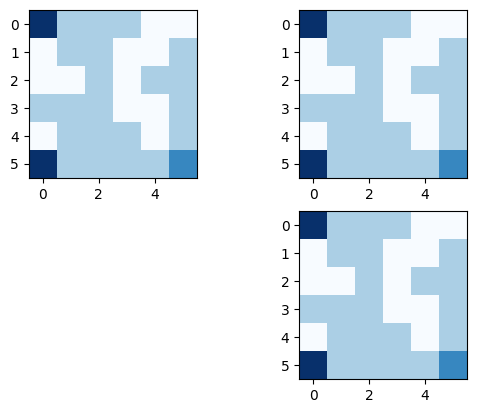

ep = 6, mse = 0.5, eps = 1.0, done = False
ep = 6, mse = 0.5, eps = 1.0, done = True
g_new = 0.4932176924827995
ep = 7, mse = 0.5, eps = 1.0, done = True
g_new = 0.07716778376032832
ep = 8, mse = 0.5, eps = 1.0, done = True
g_new = 0.05449212441583327
ep = 9, mse = 0.5, eps = 1.0, done = False
ep = 9, mse = 0.5, eps = 1.0, done = False
ep = 9, mse = 0.5, eps = 1.0, done = True
g_new = 1.091665833186961
ep = 10, mse = 0.5, eps = 1.0, done = True
g_new = 0.08158986153897768
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1.]
 [2. 1. 1. 1. 1. 4.]]

Strain Energy for Final Topology: 136037735509.6
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.583
----------------


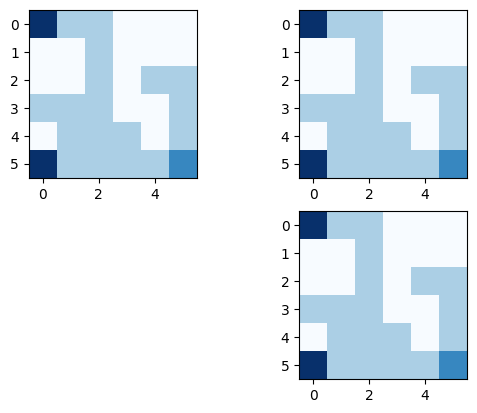

ep = 11, mse = 0.5, eps = 1.0, done = True
g_new = 0.05699283695829693
ep = 12, mse = 0.5, eps = 1.0, done = True
g_new = 0.042093416148588615
ep = 13, mse = 0.5, eps = 1.0, done = True
g_new = 0.031935803936750794
ep = 14, mse = 0.5, eps = 1.0, done = False
ep = 14, mse = 0.5, eps = 1.0, done = False
ep = 14, mse = 0.5, eps = 1.0, done = True
g_new = 1.2534887245650626
ep = 15, mse = 0.5, eps = 1.0, done = True
g_new = 0.08164982052802337
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 137326938980.3
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.528
----------------


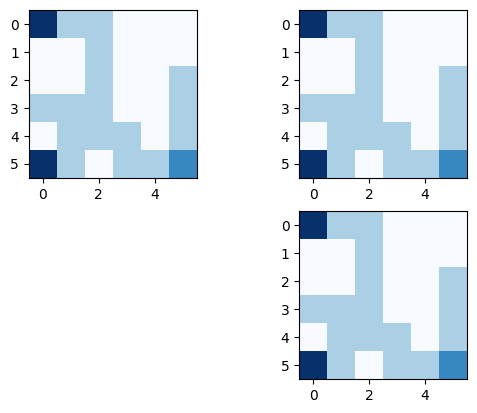

ep = 16, mse = 0.5, eps = 1.0, done = True
g_new = 0.05702620889603476
ep = 17, mse = 0.5, eps = 1.0, done = True
g_new = 0.042115247259233435
ep = 18, mse = 0.5, eps = 1.0, done = True
g_new = 0.03195125885766992
ep = 19, mse = 0.5, eps = 1.0, done = True
g_new = 0.024594040645713466
ep = 20, mse = 0.5, eps = 1.0, done = False
ep = 20, mse = 0.5, eps = 1.0, done = True
g_new = 1.0851625329184305
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 137326938980.3
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.5
----------------


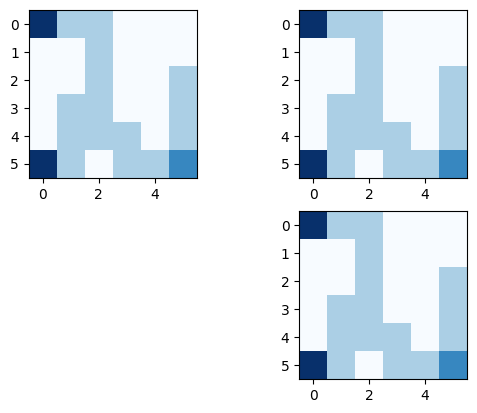

ep = 21, mse = 0.5, eps = 1.0, done = False
ep = 21, mse = 0.5, eps = 1.0, done = True
g_new = 0.5410943396935084
ep = 22, mse = 0.5, eps = 1.0, done = True
g_new = 0.07850202870943401
ep = 23, mse = 0.5, eps = 1.0, done = True
g_new = 0.055254867574229
ep = 24, mse = 0.5, eps = 1.0, done = True
g_new = 0.04095059840981888
ep = 25, mse = 0.5, eps = 1.0, done = False
ep = 25, mse = 0.5, eps = 1.0, done = True
g_new = 0.6137229272275764
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 151672762645.1
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.444
----------------


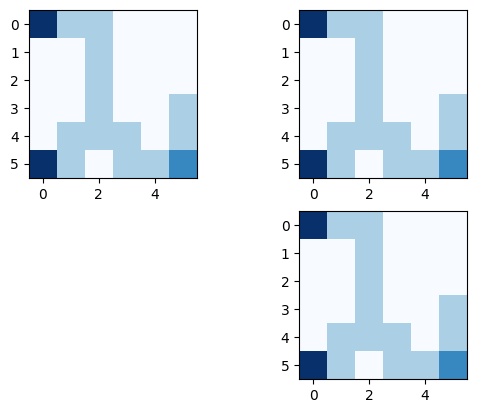

ep = 26, mse = 0.5, eps = 1.0, done = True
g_new = 0.08006530716466138
ep = 27, mse = 0.5, eps = 1.0, done = True
g_new = 0.05613949793987852
ep = 28, mse = 0.5, eps = 1.0, done = True
g_new = 0.041533734568823144
ep = 29, mse = 0.5, eps = 1.0, done = True
g_new = 0.03153904983495848
ep = 30, mse = 0.5, eps = 1.0, done = True
g_new = 0.02428925488528131
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 151672762645.1
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.444
----------------


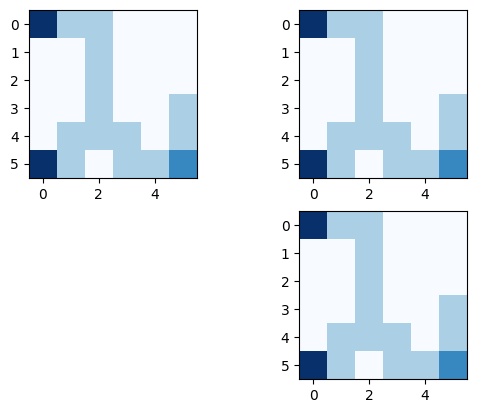

ep = 31, mse = 0.5, eps = 1.0, done = True
g_new = 0.018857780425118056
ep = 32, mse = 0.5, eps = 1.0, done = True
g_new = 0.014711635785252542
ep = 33, mse = 0.5, eps = 1.0, done = True
g_new = 0.0115112201196236
ep = 34, mse = 0.5, eps = 1.0, done = True
g_new = 0.009024163878084957
ep = 35, mse = 0.5, eps = 1.0, done = True
g_new = 0.007083541917367331
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 151672762645.1
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.444
----------------


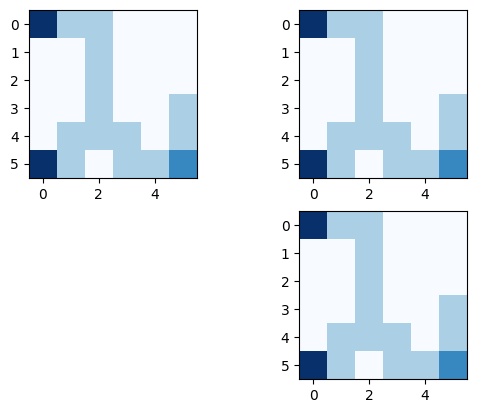

ep = 36, mse = 0.5, eps = 1.0, done = True
g_new = 0.00556550017261075
ep = 37, mse = 0.5, eps = 1.0, done = True
g_new = 0.004376191272296915
ep = 38, mse = 0.5, eps = 1.0, done = True
g_new = 0.003443544532884846
ep = 39, mse = 0.5, eps = 1.0, done = True
g_new = 0.0027117425071566895
ep = 40, mse = 0.5, eps = 1.0, done = True
g_new = 0.0021373259866850347
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 1. 0. 1.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 151672762645.1
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.444
----------------


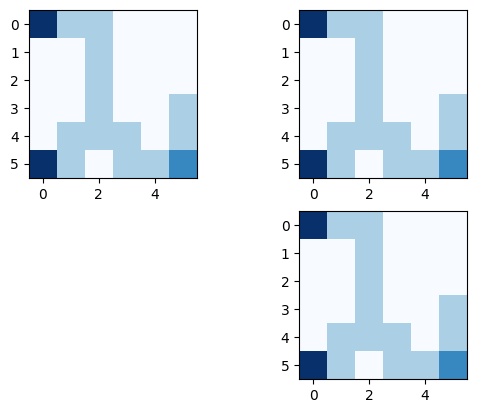

ep = 41, mse = 0.5, eps = 1.0, done = True
g_new = 0.001686345983725568
ep = 42, mse = 0.5, eps = 1.0, done = True
g_new = 0.0013322281827038208
ep = 43, mse = 0.5, eps = 1.0, done = True
g_new = 0.0010541444937727463
ep = 44, mse = 0.5, eps = 1.0, done = True
g_new = 0.0008357576675920742
ep = 45, mse = 0.5, eps = 1.0, done = False
ep = 45, mse = 0.5, eps = 1.0, done = True
g_new = 0.7110152343373056
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 157300333120.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.417
----------------


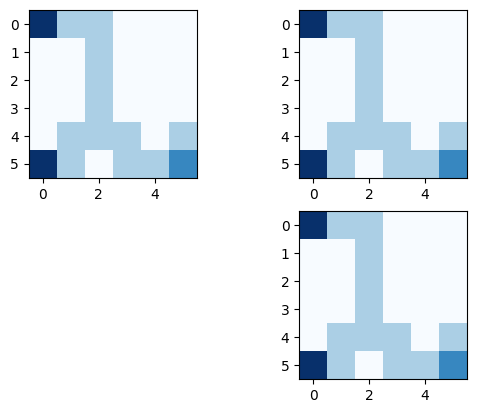

ep = 46, mse = 0.5, eps = 1.0, done = True
g_new = 0.08157757730526767
ep = 47, mse = 0.5, eps = 1.0, done = True
g_new = 0.056985998044013254
ep = 48, mse = 0.5, eps = 1.0, done = True
g_new = 0.04208894176995914
ep = 49, mse = 0.5, eps = 1.0, done = True
g_new = 0.03193263619008762
ep = 50, mse = 0.5, eps = 1.0, done = True
g_new = 0.02458028112823838
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 157300333120.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.417
----------------


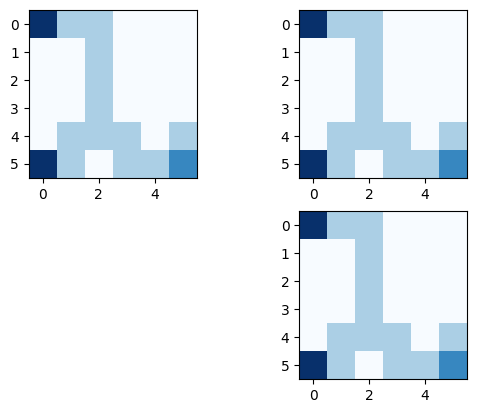

ep = 51, mse = 0.5, eps = 1.0, done = True
g_new = 0.019078224688361622
ep = 52, mse = 0.5, eps = 1.0, done = True
g_new = 0.014881008597917812
ep = 53, mse = 0.5, eps = 1.0, done = False
ep = 53, mse = 0.5, eps = 1.0, done = True
g_new = 0.7570892594685196
ep = 54, mse = 0.5, eps = 1.0, done = True
g_new = 0.08213451460213861
ep = 55, mse = 0.5, eps = 1.0, done = True
g_new = 0.05729545540852532
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 159728722955.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.389
----------------


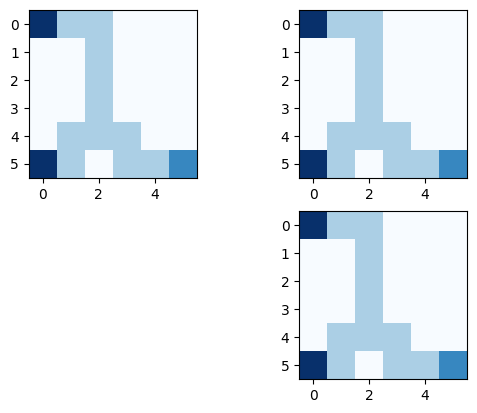

ep = 56, mse = 0.5, eps = 1.0, done = True
g_new = 0.04229122551486009
ep = 57, mse = 0.5, eps = 1.0, done = True
g_new = 0.03207578156028037
ep = 58, mse = 0.5, eps = 1.0, done = True
g_new = 0.024686020860946692
ep = 59, mse = 0.5, eps = 1.0, done = True
g_new = 0.019158273227366164
ep = 60, mse = 0.5, eps = 1.0, done = True
g_new = 0.014942490648497687
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 159728722955.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.389
----------------


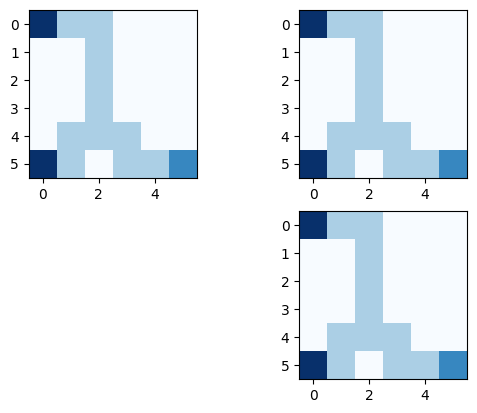

ep = 61, mse = 0.5, eps = 1.0, done = True
g_new = 0.011690103471895343
ep = 62, mse = 0.5, eps = 1.0, done = True
g_new = 0.009163499619868043
ep = 63, mse = 0.5, eps = 1.0, done = True
g_new = 0.007192419202502843
ep = 64, mse = 0.5, eps = 1.0, done = True
g_new = 0.0056507434712171015
ep = 65, mse = 0.5, eps = 1.0, done = True
g_new = 0.004443011076967984
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 159728722955.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.389
----------------


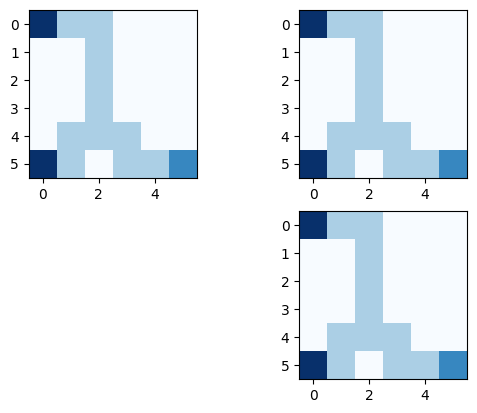

ep = 66, mse = 0.5, eps = 1.0, done = True
g_new = 0.003495961514439228
ep = 67, mse = 0.5, eps = 1.0, done = True
g_new = 0.002752879974899303
ep = 68, mse = 0.5, eps = 1.0, done = True
g_new = 0.0021696202940742594
ep = 69, mse = 0.5, eps = 1.0, done = True
g_new = 0.0017117025507893625
ep = 70, mse = 0.5, eps = 1.0, done = True
g_new = 0.001352139595734836
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 159728722955.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.389
----------------


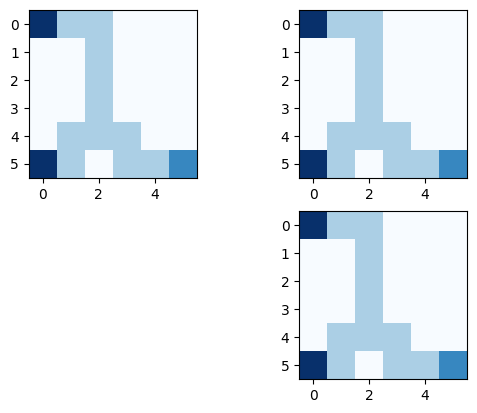

ep = 71, mse = 0.5, eps = 1.0, done = True
g_new = 0.0010697811170370386
ep = 72, mse = 0.5, eps = 1.0, done = True
g_new = 0.000848037772151189
ep = 73, mse = 0.5, eps = 1.0, done = True
g_new = 0.0006738910870266679
ep = 74, mse = 0.5, eps = 1.0, done = True
g_new = 0.0005371216373082355
ep = 75, mse = 0.5, eps = 1.0, done = True
g_new = 0.0004297056837531566
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 159728722955.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.389
----------------


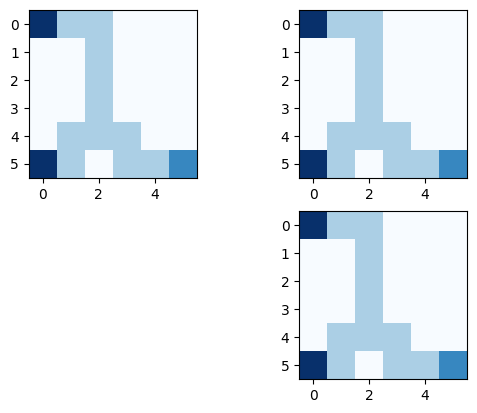

ep = 76, mse = 0.5, eps = 1.0, done = True
g_new = 0.0003453426633038825
ep = 77, mse = 0.5, eps = 1.0, done = True
g_new = 0.0002790847504072325
ep = 78, mse = 0.5, eps = 1.0, done = True
g_new = 0.000227046241816109
ep = 79, mse = 0.5, eps = 1.0, done = True
g_new = 0.0001861754678164962
ep = 80, mse = 0.5, eps = 1.0, done = True
g_new = 0.0001540757301803586
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 159728722955.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.389
----------------


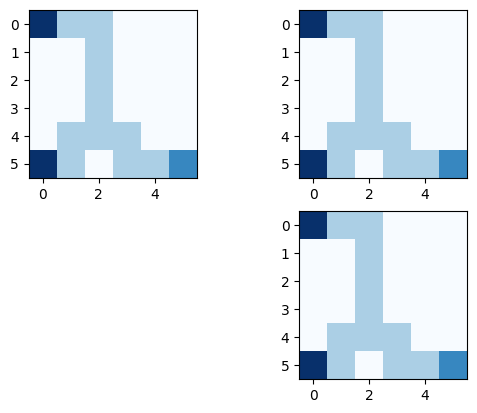

ep = 81, mse = 0.5, eps = 1.0, done = True
g_new = 0.00012886470579605015
ep = 82, mse = 0.5, eps = 1.0, done = True
g_new = 0.00010906404164052753
ep = 83, mse = 0.5, eps = 1.0, done = True
g_new = 9.351265236794415e-05
ep = 84, mse = 0.5, eps = 1.0, done = True
g_new = 8.129862914323383e-05
ep = 85, mse = 0.5, eps = 1.0, done = True
g_new = 7.170576335764345e-05
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 159728722955.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.389
----------------


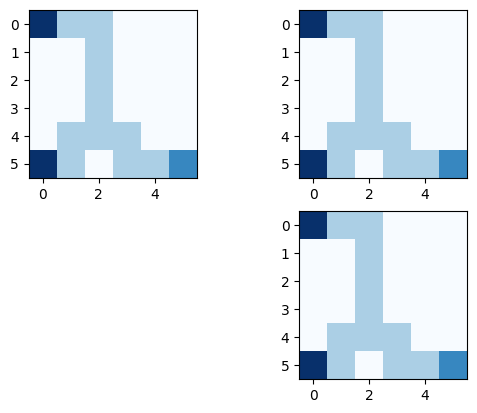

ep = 86, mse = 0.5, eps = 1.0, done = True
g_new = 6.417154766973354e-05
ep = 87, mse = 0.5, eps = 1.0, done = True
g_new = 5.825419072520433e-05
ep = 88, mse = 0.5, eps = 1.0, done = True
g_new = 5.360671090377523e-05
ep = 89, mse = 0.5, eps = 1.0, done = True
g_new = 4.9956589766919635e-05
ep = 90, mse = 0.5, eps = 1.0, done = True
g_new = 4.708979200518382e-05
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 159728722955.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.389
----------------


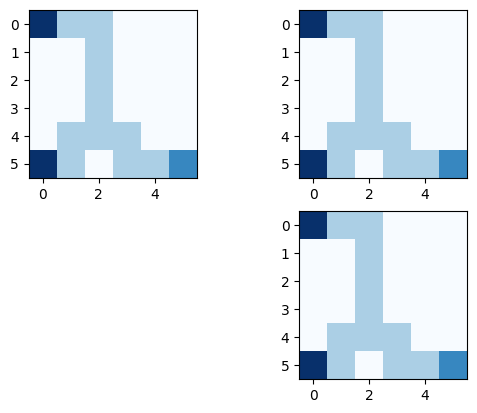

ep = 91, mse = 0.5, eps = 1.0, done = True
g_new = 4.483821478415973e-05
ep = 92, mse = 0.5, eps = 1.0, done = True
g_new = 4.306983051176605e-05
ep = 93, mse = 0.5, eps = 1.0, done = True
g_new = 4.168094500152098e-05
ep = 94, mse = 0.5, eps = 1.0, done = True
g_new = 4.059011705723759e-05
ep = 95, mse = 0.5, eps = 1.0, done = True
g_new = 3.973338293141726e-05
----------------
The final topology: 
BC Element #0: 0
BC Element #1: 30
LC Element #0: 5
Load Type: Tensile
Load Direction: Vertical
[[2. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [2. 1. 0. 1. 1. 4.]]

Strain Energy for Final Topology: 159728722955.4
Maximum P_Norm Stress Perc Increase: 0.0
Final Volume Fraction: 0.389
----------------


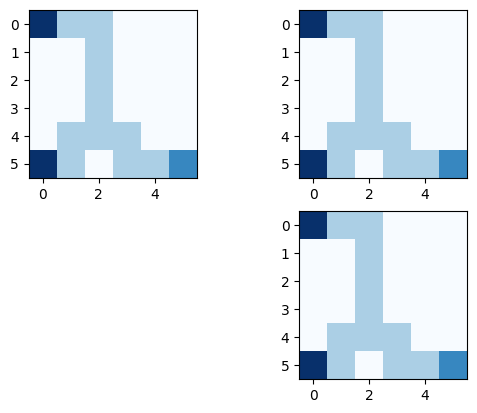

ep = 96, mse = 0.5, eps = 1.0, done = True
g_new = 3.906050562696439e-05
ep = 97, mse = 0.5, eps = 1.0, done = True
g_new = 3.853202910741871e-05
ep = 98, mse = 0.5, eps = 1.0, done = True
g_new = 3.811696468054571e-05
ep = 99, mse = 0.5, eps = 1.0, done = True
g_new = 3.7790973888940374e-05


In [7]:

for ep in range(100):
    g_new = 0
    done = False

    while not done:
        act = agent.choose_action(obs, load_checkpoint=False, Testing=False)
        obs2, rew, done, _ = agent.env.step(observation = obs, action=act,Last_Reward=rew, load_checkpoint=False, env=opts, PR=False, FEA_Skip=FEA_SKIP) # do FEA for every 10 steps

        # store transition in memory
        agent.memory.store_transition(obs, act, rew, obs2, done)

        # plot
        # agent.env.render()

        # update state
        obs = obs2
        g_new += rew * agent.gamma

        # learn
        mse = agent.learn()
        print(f"ep = {ep}, mse = {mse}, eps = {eps}, done = {done}")

        if done:
            obs = env.reset()
            print(f"g_new = {g_new}")
            g_rew = 0

    # test 실행
    if ep % TEST_FREQ == 0:
            Testing_Inputs(env=agent.env, opts=opts)
            Testing_Info(env=agent.env, env_primer=agent.env, env_primer2=agent.env, opts=opts,
                         score=None, Progressive_Refinement=False, From_App=False, Fixed=None)
            


            



